# Music Genre Classification 
### by @fcacharelli and @mdtc

In [1]:
#install Speech lib

#import pip

#package_names=['python_speech_features'] #packages to install
#pip.main(['install'] + package_names + ['--upgrade']) # --upgrade to install or update existing packages

#pip install python_speech_features #in case of not having it installed 

## 1. Import Libraries

In [2]:
# Import libraries 

from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np
from tempfile import TemporaryFile
import os
import pickle
import random 
import operator
import math
import numpy as np

In [10]:
import pandas as pd

In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Load DataSet

In [128]:
Genres = {
    1: "Blues",
    2: "Classical",
    3: "Country",
    4: "Disco",
    5: "Hip Hop",
    6: "Jazz",
    7: "Metal",
    8: "Pop",
    9: "Reggae",
    10: "Rock"
}

In [5]:
# Prepare Dataset
# Practice only, use master branch's dataset.

directory = os.path.dirname(os.path.realpath("MLMusicGenre")) + "\\data"
f= open("mgenres.dat" ,'wb')
i=0
for folder in os.listdir(directory):
    i+=1
    if i==11 :
        break   
    for file in os.listdir(directory+"\\"+folder):  
        (rate,sig) = wav.read(directory+"\\"+folder+"\\"+file)
        mfcc_feat = mfcc(sig,rate ,winlen=0.020, appendEnergy = False)
        covariance = np.cov(np.matrix.transpose(mfcc_feat))
        mean_matrix = mfcc_feat.mean(0)
        feature = (mean_matrix , covariance , i)
        pickle.dump(feature , f)
f.close() 

In [7]:
# Load Dataset

def loadDataSet(fileName):
    with open(fileName, "rb") as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break
    
dataset=[]
loadDataSet("genres.dat")

In [69]:
# Convert to Pandas Data Frame

dataset = pd.DataFrame(dataset)
dataset

,0,1,2
0,"[76.5026110677372, -1.9614173589380144, -15.77...","[[31.364326631614066, -1.3468342058680451, -0....",1
1,"[66.93164964522649, 0.7188534538996809, -3.267...","[[107.79187315415385, -31.411100328803215, -9....",1
2,"[78.7741031258866, 3.039700087120104, -19.0244...","[[41.929518828588385, -21.58695775545638, -30....",1
3,"[66.69610667522518, 9.211514465758532, -4.5328...","[[70.07832382282082, -31.52905508596631, 2.620...",1
4,"[71.97284566377586, 0.5064100190354653, -23.83...","[[73.97934723712848, -49.0136740941537, -34.35...",1
...,...,...,...
995,"[73.39782483055345, -4.459683299978229, -14.65...","[[21.58115076126584, -17.780006213473275, -4.3...",10
996,"[73.96549448871167, -4.293810209685265, -18.14...","[[36.05839587905572, -21.80388797679555, -7.00...",10
997,"[75.55902537392254, -5.658250351745185, -24.03...","[[18.18242292339917, -15.896549001368685, -7.1...",10
998,"[65.61635032690315, 2.2903386914587833, -10.02...","[[122.2511166206538, -35.56627502776603, -71.1...",10


There are 1000 rows, each contains an array of 13 elements in column 0,
A 13x13 matrix in column 1 and Class identifier (1-10) in column 2.
We will try to use the 13 elements array as a genre predictor.

In [70]:

df = pd.DataFrame(columns=["f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12","f13"])
for i in range(0,1000):
    array = []
    for j in range(0,13):
        array.append(dataset.iloc[i][0][j])
    df=df.append(dict(zip(df.columns, array)), ignore_index=True)
df["Class"] = dataset[2]
df

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,Class
0,76.502611,-1.961417,-15.774347,3.831419,-10.473326,1.311828,-19.393732,5.286790,-16.631725,5.353444,-9.856570,6.250077,-5.587495,1
1,66.931650,0.718853,-3.267830,4.181200,-8.050941,6.448259,-17.768517,14.091810,-18.332536,3.685560,-10.550744,2.887485,-7.788083,1
2,78.774103,3.039700,-19.024435,-0.983591,-14.699337,7.586562,-12.823053,1.892920,-14.865326,3.595252,-13.961705,1.066102,-6.196685,1
3,66.696107,9.211514,-4.532876,5.027148,-8.254011,8.101201,-9.676610,9.824043,-6.735213,10.332956,-10.185683,5.412514,-6.100144,1
4,71.972846,0.506410,-23.834838,-2.181944,-29.875498,0.719521,-19.039014,-1.353935,-13.370416,5.069944,-11.607831,-1.471467,-4.666507,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,73.397825,-4.459683,-14.651107,11.283542,-8.375529,-3.662607,-18.204311,6.734539,-17.631765,7.386032,-8.350394,6.484662,-11.819871,10
996,73.965494,-4.293810,-18.142045,6.038423,-8.450073,2.086841,-18.216358,8.046921,-17.254868,2.744055,-12.322725,10.490974,-8.910196,10
997,75.559025,-5.658250,-24.032933,9.404209,-9.382920,0.403674,-12.090986,4.009819,-16.158074,-1.940495,-15.799928,4.584265,-9.707774,10
998,65.616350,2.290339,-10.020879,15.967210,0.475585,3.193512,-19.001698,4.452534,-15.411609,7.730426,-14.628185,3.267224,-12.534688,10


## 3. Standardize Scale

In [71]:
# Create an instance of the StandardScaler

scaler = StandardScaler()

In [72]:
# Fit the Scaler to the data, except the Target Class

scaler.fit(df.drop("Class",axis=1))

StandardScaler()

In [73]:
# Actually transform the data into an array

scaled_features = scaler.transform(df.drop("Class",axis=1))

In [74]:
# Cast array to DataFrame

df_feat = pd.DataFrame(scaled_features, columns=df.columns[:-1])

In [75]:
df_feat

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13
0,0.270973,0.406377,-0.484429,-0.052830,-0.417845,0.185047,-1.269000,0.388670,-0.908405,0.500927,-0.405657,1.013750,-0.195325
1,-0.714168,0.684118,0.880624,-0.011946,-0.081149,0.828982,-1.058493,1.583108,-1.148978,0.213563,-0.520036,0.289756,-0.663714
2,0.504779,0.924613,-0.839167,-0.615631,-1.005234,0.971687,-0.417927,-0.071723,-0.658554,0.198004,-1.082060,-0.102402,-0.324989
3,-0.738413,1.564162,0.742548,0.086932,-0.109374,1.036205,-0.010381,1.004167,0.491420,1.358859,-0.459885,0.833416,-0.304441
4,-0.195277,0.662103,-1.364210,-0.755700,-3.114626,0.110791,-1.223055,-0.512172,-0.447105,0.452082,-0.694212,-0.648762,0.000705
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.048603,0.147496,-0.361830,0.818209,-0.126264,-0.438580,-1.114939,0.585063,-1.049857,0.851126,-0.157485,1.064258,-1.521870
996,0.009827,0.164685,-0.742857,0.205135,-0.136626,0.282207,-1.116500,0.763093,-0.996546,0.051349,-0.812005,1.926850,-0.902553
997,0.173850,0.023296,-1.385832,0.598543,-0.266285,0.071195,-0.323105,0.215443,-0.841409,-0.755763,-1.384944,0.655087,-1.072316
998,-0.849552,0.846961,0.143547,1.365658,1.103985,0.420946,-1.218221,0.275500,-0.735824,0.910463,-1.191876,0.371517,-1.674017


## 4.  Split data

In [77]:
# Use train_test_split to split randomly, having 30% of the data for testing.

X = df_feat
y = df["Class"]

X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## 5. Apply KNN Model

In [78]:
# Instance of the classifier with k=1

knn = KNeighborsClassifier(n_neighbors=1)

In [79]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [80]:
# Calculate predictions

pred = knn.predict(X_test)

## 6. Evaluate

In [81]:
# Confusion Matrix and Classification Report

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[16  0  1  3  0  2  1  0  0  1]
 [ 1 36  1  0  0  1  1  0  0  0]
 [ 0  0 19  1  1  3  0  2  1  1]
 [ 1  1  1 10  2  3  0  3  3  5]
 [ 0  0  1  3 14  1  3  3  3  2]
 [ 1  3  2  2  3 12  0  0  0  1]
 [ 6  0  1  3  4  0 18  0  0  0]
 [ 0  0  1  2  2  2  0 17  1  1]
 [ 0  0  3  1  7  2  0  3 20  1]
 [ 2  1  2  4  3  3  0  1  1 13]]
              precision    recall  f1-score   support

           1       0.59      0.67      0.63        24
           2       0.88      0.90      0.89        40
           3       0.59      0.68      0.63        28
           4       0.34      0.34      0.34        29
           5       0.39      0.47      0.42        30
           6       0.41      0.50      0.45        24
           7       0.78      0.56      0.65        32
           8       0.59      0.65      0.62        26
           9       0.69      0.54      0.61        37
          10       0.52      0.43      0.47        30

    accuracy                           0.58       300
   macro avg       

##  7. Optimize

In [97]:
# Iterate the model for different k values and calculate Error Rates 
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    prediction = knn.predict(X_test)
    error_rate.append(np.mean(prediction!=y_test)) # Mean of boolean array, 1: mistake, 0: right

Text(0, 0.5, 'Error Rate')

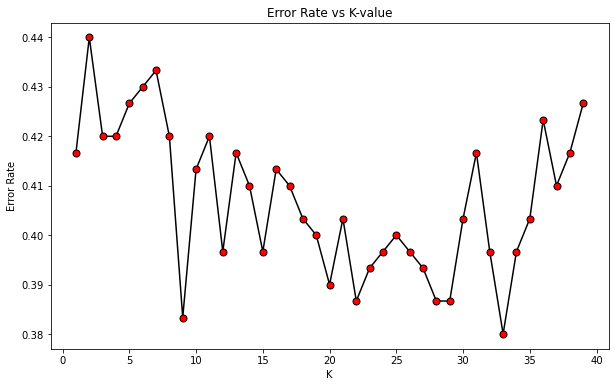

In [98]:
# Plot error rates to optimize k value

plt.figure(figsize=(10,6))
plt.plot(range(1,40), 
         error_rate, 
         color="black", 
         linestyle="-", 
         marker="o", 
         markerfacecolor="red", 
         markersize=7)
plt.title("Error Rate vs K-value")
plt.xlabel("K")
plt.ylabel("Error Rate")

## 8. Choose K-value
We will use k=33

In [101]:
knn = KNeighborsClassifier(n_neighbors=33)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print(confusion_matrix(y_test,pred))
print("\n")
print(classification_report(y_test,pred))

[[14  0  4  0  0  1  2  0  0  3]
 [ 0 36  2  0  0  0  2  0  0  0]
 [ 1  1 16  2  0  2  0  5  1  0]
 [ 0  1  2 15  2  0  1  5  0  3]
 [ 0  0  1  1 11  0  5  7  4  1]
 [ 1  8  3  3  0  6  0  1  1  1]
 [ 0  0  1  1  0  0 28  1  0  1]
 [ 0  0  0  0  0  0  0 26  0  0]
 [ 0  2  7  1  1  0  1  5 18  2]
 [ 1  0  3  6  0  0  0  2  2 16]]


              precision    recall  f1-score   support

           1       0.82      0.58      0.68        24
           2       0.75      0.90      0.82        40
           3       0.41      0.57      0.48        28
           4       0.52      0.52      0.52        29
           5       0.79      0.37      0.50        30
           6       0.67      0.25      0.36        24
           7       0.72      0.88      0.79        32
           8       0.50      1.00      0.67        26
           9       0.69      0.49      0.57        37
          10       0.59      0.53      0.56        30

    accuracy                           0.62       300
   macro avg     

## 9. Test Model

In [133]:
(rate,sig)=wav.read("bob marley.wav")
mfcc_feat=mfcc(sig,rate,winlen=0.020,appendEnergy=False)
covariance = np.cov(np.matrix.transpose(mfcc_feat))
mean_matrix = mfcc_feat.mean(0)
feature=(mean_matrix,covariance,0)


In [135]:
knn = KNeighborsClassifier(n_neighbors=33)
knn.fit(X_train,y_train)
pred = knn.predict() #Transpose
print(Genres[pred[0]])

Pop
